In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
ticker = 'NFLX'
benchmark = 'SPY'
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
data = yf.download([ticker,benchmark], start, end)

df = pd.DataFrame(index = data.index)
data.head(5)

[*********************100%***********************]  2 of 2 completed


Adj Close                   Close                    High  \
                  NFLX         SPY        NFLX         SPY        NFLX   
Date                                                                     
2022-12-01  316.950012  401.066345  316.950012  407.380005  319.799988   
2022-12-02  320.410004  400.603638  320.410004  406.910004  321.989990   
2022-12-05  312.589996  393.397064  312.589996  399.589996  322.769989   
2022-12-06  305.559998  387.726318  305.559998  393.829987  313.220001   
2022-12-07  308.420013  387.066711  308.420013  393.160004  309.609985   

                               Low                    Open              \
                   SPY        NFLX         SPY        NFLX         SPY   
Date                                                                     
2022-12-01  410.000000  303.029999  404.750000  303.989990  408.769989   
2022-12-02  407.859985  310.000000  402.140015  310.489990  402.250000   
2022-12-05  404.929993  310.920013  398.170013  316.459991  403.950012   
2022-12-06  399.989990  303.130005  391.640015  311.000000  399.420013   
2022-12-07  395.640015  302.100006  391.970001  306.500000  392.940002   

              Volume            
                NFLX       SPY  
Date                            
2022-12-01  14664900  76398200  
2022-12-02  12690600  85342700  
2022-12-05   8423000  77289800  
2022-12-06   7195400  77972200  
2022-12-07   7821600  65927900

In [3]:
# Calculate EMA (Exponential Moving Average)
df['EMA10'] = ta.trend.ema_indicator(data['Close', ticker], window=10)
df['EMA30'] = ta.trend.ema_indicator(data['Close', ticker], window=30)

# Calculate ATR (Average True Range)
df['ATR'] = ta.volatility.average_true_range(data['High', ticker], data['Low', ticker], data['Close', ticker], window=14)

# Calculate ADX (Average Directional Index)
df['ADX'] = ta.trend.adx(data['High', ticker], data['Low', ticker], data['Close', ticker], window=14)

# Calculate RSI (Relative Strength Index)
df['RSI'] = ta.momentum.rsi( data['Close', ticker], window=14)

# Calculate MACD (Moving Average Convergence Divergence)
df['MACD'] = ta.trend.macd( data['Close', ticker], window_slow=26, window_fast=12)

# Calculate MACD Signal line
df['MACD_signal'] = ta.trend.macd_signal( data['Close', ticker], window_slow=26, window_fast=12, window_sign=9)

df.shape[0]

251

# Introduce features

In [4]:
df['Close_EMA_10'] = np.where(data['Close', ticker]> df['EMA10'], 1, -1)
df['EMA_10_EMA_30'] = np.where(df['EMA10'] > df['EMA30'], 1, -1)
df['MACD_Signal_MACD'] = np.where(df['MACD_signal'] > df['MACD'], 1, -1)

df.tail(11)

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD
Date,,,,,,,,,,
2023-11-15,439.788375,417.860427,10.692621,34.092263,75.051370,16.089327,12.337624,1,1,-1
2023-11-16,444.726854,421.027497,10.473862,35.840265,76.448700,17.334297,13.336959,1,1,-1
2023-11-17,448.578336,423.923143,10.075014,37.479103,75.503331,18.029196,14.275406,1,1,-1
2023-11-20,453.285912,427.184230,10.166800,39.363780,77.923186,19.051020,15.230529,1,1,-1
2023-11-21,457.224839,430.265894,9.855600,41.123579,78.054103,19.672780,16.118979,1,1,-1
2023-11-22,461.002141,433.345513,9.705200,42.967389,78.909902,20.179027,16.930989,1,1,-1
2023-11-24,464.376297,436.327093,9.383398,44.433906,79.353386,20.470143,17.638820,1,1,-1
2023-11-27,467.066063,439.091152,9.188155,45.861979,78.906681,20.433837,18.197823,1,1,-1
2023-11-28,469.235870,441.665917,8.856858,47.188047,78.698690,20.158966,18.590052,1,1,-1


<h2>Creating the target variables</h2>
This are the variables whose values are to be modeled and predicted by othervariables. There must be one and only one target variable in a decision tree analysis.
The target variable for the classification algorithm also uses the lagged return, butbecause the output is categorical, we must transform it. If the return was positive,we assign 1 and if it was negative, we assign 0.

In [5]:
df['returned'] = np.log(data['Close', ticker]/data['Close', ticker].shift(1))
df['return_'+benchmark] = np.log(data['Close', benchmark]/data['Close', benchmark].shift(1))
df['target'] = np.where(df['returned'] > 0, 1, 0)

df

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD,returned,return_SPY,target
Date,,,,,,,,,,,,,
2022-12-01,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,0
2022-12-02,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,0.010857,-0.001154,1
2022-12-05,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,-0.024709,-0.018153,0
2022-12-06,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,-0.022746,-0.014520,0
2022-12-07,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,0.009316,-0.001703,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,464.376297,436.327093,9.383398,44.433906,79.353386,20.470143,17.638820,1,1,-1,0.003258,0.000615,1
2023-11-27,467.066063,439.091152,9.188155,45.861979,78.906681,20.433837,18.197823,1,1,-1,-0.000814,-0.001803,0
2023-11-28,469.235870,441.665917,8.856858,47.188047,78.698690,20.158966,18.590052,1,1,-1,-0.000355,0.000990,0


In [6]:
X = df[['ATR', 'ADX','RSI', 'Close_EMA_10', 'EMA_10_EMA_30', 'MACD_Signal_MACD']] #features
y = df.target #target

X_clean = X.dropna()
Y_clean = y[X.index.isin(X_clean.index)]

X=X_clean
y=Y_clean

#splitting the data and building the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [7]:
df.describe()

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD,returned,return_SPY,target
count,242.000000,222.000000,251.000000,251.000000,238.000000,226.000000,218.000000,251.000000,251.000000,251.000000,250.000000,250.000000,251.000000
mean,375.590094,376.419440,11.186697,24.499489,54.255413,4.051814,3.785433,0.123506,0.163347,-0.123506,0.001610,0.000454,0.521912
std,50.294153,43.325754,2.894424,13.565531,14.265345,9.978115,9.217013,0.994327,0.988540,0.994327,0.024250,0.008821,0.500518
min,292.543727,310.472888,0.000000,0.000000,27.047358,-13.857003,-12.532088,-1.000000,-1.000000,-1.000000,-0.090223,-0.024766,0.000000
25%,330.269361,330.284671,10.788833,17.299587,43.259459,-2.788802,-2.799629,-1.000000,-1.000000,-1.000000,-0.011748,-0.005101,0.000000
50%,375.160461,386.619929,11.753124,23.107458,56.009725,3.248293,2.910034,1.000000,1.000000,-1.000000,0.001117,0.000444,1.000000
75%,424.132605,421.959465,12.549486,28.496449,65.364520,13.151616,11.956607,1.000000,1.000000,1.000000,0.011837,0.006459,1.000000
max,471.279881,445.894065,15.685868,54.535586,82.128931,24.346251,21.592106,1.000000,1.000000,1.000000,0.148892,0.022673,1.000000


Import all machine learning models

In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [9]:
def plot_models(results, names):
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

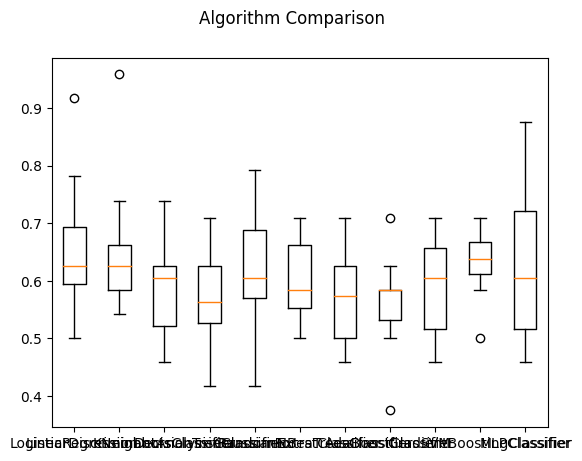

In [10]:
seed = 7
models = []

models.append(('LogisticRegression', LogisticRegression(random_state=seed)))
models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('ExtraTreesClassifier',ExtraTreesClassifier(random_state=seed)))
models.append(('AdaBoostClassifier',AdaBoostClassifier(DecisionTreeClassifier(random_state=seed),random_state=seed,learning_rate=0.1)))
models.append(('SVM',svm.SVC(random_state=seed)))
models.append(('GradientBoostingClassifier',GradientBoostingClassifier(random_state=seed)))
models.append(('MLPClassifier',MLPClassifier(random_state=seed)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg) 

#print(results, names)
plot_models(results, names)

# Hyper-parameter Tuning

In [11]:
param_grid={
    'n_estimators':[100,200,300],
    'max_depth':[10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

In [12]:
#for name, model in models:
    #grid_search = GridSearchCV(estimator = model, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=42), param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

best_params=grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_model=RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train,y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(max_depth=10, random_state=42)

# Performance Evaluation

In [13]:
y_pred=best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.53      0.58        34
           1       0.64      0.74      0.68        38

    accuracy                           0.64        72
   macro avg       0.64      0.63      0.63        72
weighted avg       0.64      0.64      0.63        72



In [14]:
accuracy=accuracy_score(y_test,y_pred)
print(f"Accuracy:{accuracy}")

Accuracy:0.6388888888888888


In [15]:
df.head(5)

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD,returned,return_SPY,target
Date,,,,,,,,,,,,,
2022-12-01,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,0
2022-12-02,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,0.010857,-0.001154,1
2022-12-05,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,-0.024709,-0.018153,0
2022-12-06,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,-0.022746,-0.014520,0
2022-12-07,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,0.009316,-0.001703,1


In [16]:
df.columns

Index(['EMA10', 'EMA30', 'ATR', 'ADX', 'RSI', 'MACD', 'MACD_signal',
       'Close_EMA_10', 'EMA_10_EMA_30', 'MACD_Signal_MACD', 'returned',
       'return_SPY', 'target'],
      dtype='object')

Plot graph to check which strategy is working

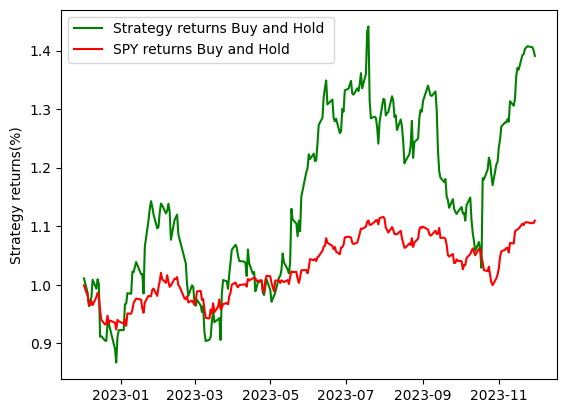

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total 

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total 

In [17]:
train_length=0
#plt.plot((df.strategy_returns[train_length:]+1).cumprod(),'b-',label='Strategy returns decision tree ')
plt.plot((df.returned[train_length:]+1).cumprod(),'g-',label='Strategy returns Buy and Hold ')
plt.plot((df['return_'+benchmark][train_length:]+1).cumprod(),'r-',label=benchmark+' returns Buy and Hold ')
plt.ylabel('Strategy returns(%)')
plt.legend()
plt.show()